In [7]:
import numpy as np  
import pickle
from sklearn.decomposition import PCA
import gpflow

/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nramachandra

In [27]:
def modelLoad(nRankMax, snap_ID):
    GPmodel = modelDir + 'GP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  
    PCAmodel = modelDir + 'PCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  

    ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
    saver = gpflow.saver.Saver()
    GPm = saver.load(GPmodel, context=ctx_for_loading)
    GPm.clear()
    GPm.compile()
    PCAm = pickle.load(open(PCAmodel, 'rb'))
    return GPm, PCAm

def GPy_predict(gpmodel, para_array):
    m1p = gpmodel.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(gpmodel, pcamodel, para_array):
    para_array = np.array(para_array)
    if len(para_array.shape) == 1:
        W_predArray, _ = GPy_predict(gpmodel, np.expand_dims(para_array, axis=0))
        x_decoded = pcamodel.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]

def MGemu(Om, ns, s8, fR0, n, z):
    snap_idx_nearest = (np.abs(z_all - z)).argmin()
    if (z > z_all[snap_idx_nearest]): 
        snap_ID_z1 = snap_idx_nearest - 1    
    else:
        snap_ID_z1 = snap_idx_nearest 
    snap_ID_z2 = snap_ID_z1 + 1

    GPm1, PCAm1 = modelLoad(nRankMax, snap_ID_z1)
    Pk_z1 = Emu(GPm1, PCAm1, [Om, ns, s8, fR0, n])
    z1 = z_all[snap_ID_z1]

    GPm2, PCAm2 = modelLoad(nRankMax, snap_ID_z2)
    Pk_z2 = Emu(GPm2, PCAm2, [Om, ns, s8, fR0, n])
    z2 = z_all[snap_ID_z2]
    
    print('Linear interpolating for redshift between', 'z1= '+ str(z_all[snap_ID_z1]), 'z2= '+ str(z_all[snap_ID_z2]))
    Pk_interp = np.zeros_like(Pk_z1)
    Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
    return Pk_interp


In [28]:
nRankMax = 16
snap_ID = 61
del_idx = [5, 25, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 


dataDir = "./Data/Emulator213bins/" ## Data folder
modelDir = "./Models/" ## Data folder

az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbins_' + str(99) + '.txt'

loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]
z_all = az[:, 1]

In [29]:
# Om, ns, s8, fR0, n = 0.1, 1.0, 0.8, 3e-5, 1.5

# MGemu(Om=0.1, ns=1.0, s8=0.8, fR0=3e-5, n=1.5, z=0.02)

In [30]:
Om_f=0.281
ns_f=0.971
s8_f=0.82
z_f=0.505668030951772
n_f=1
fr0_f4 = 1e-4
fr0_f5 = 1e-5
fr0_f6 = 1e-6

In [31]:
emu_f4= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_f)
emu_f5= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_f)
emu_f6= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_f)

/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/gpflow/saver/serializers.py:46: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(pathname_or_file_like) as h5file:
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/gpflow/saver/serializers.py:47: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return h5file['data'].value
Linear interpolating for redshift between z1= 0.52207 z2= 0.4997
Linear interpolating for redshift between z1= 0.52207 z2= 0.4997
Linear interpolating for redshift between z1= 0.52207 z2= 0.4997


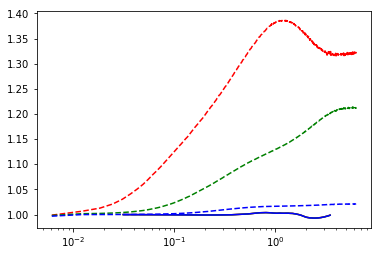

In [42]:
import matplotlib.pylab as plt

nbody = np.loadtxt('./Data/Nbody_validation/ratiosz05.txt', skiprows=1)


plt.plot(kvals, emu_f4, 'r')
plt.plot(nbody[:,0], nbody[:, 1], 'r--')
plt.plot(kvals, emu_f5, 'g')
plt.plot(nbody[:,0], nbody[:, 2], 'g--')

plt.plot(kvals, emu_f6, 'b')
plt.plot(nbody[:,0], nbody[:, 3], 'b--')

plt.xscale('log')

plt.show()